In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *

## Examples of Heteroskedasticity 

In [2]:
df = pd.read_csv('../data/kc_house_data.csv')

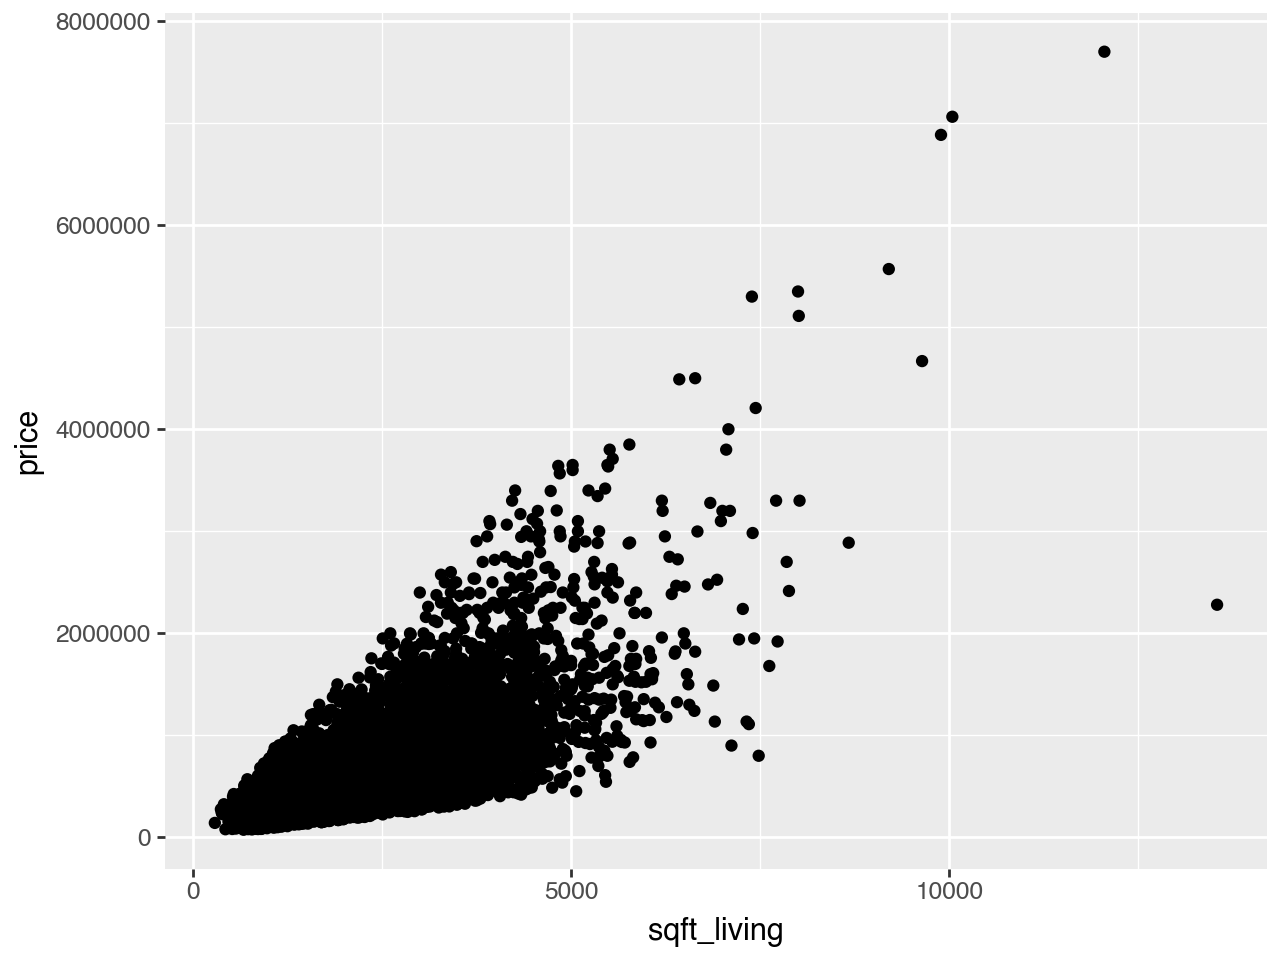

In [3]:
(ggplot(df, aes(x = 'sqft_living', y = 'price')) + 
       geom_point())

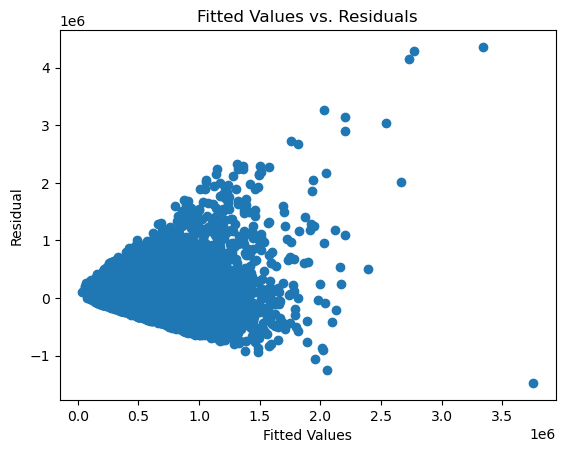

In [4]:
f = 'price~sqft_living'
model = smf.ols(formula=f, data=df).fit()
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

#### The classic fan shape emblematic of heteroskedasticity

## Problems associated with heteroskedasticity:
- $\hat{\beta}$ is still unbiased but no longer BLUE (i.e. it's not the minimum variance estimator out of all linear estimators)
- Our estimate $\widehat{SE}({\hat{\beta}})$ is wrong now and $\therefore$ CI and PI widths are also wrong

## One option: Transforming the Response

Normally when we see the "fan" shape in the residual plot, a log transformation on $y$ helps mitigate heteroskedasticity.

In [5]:
df['log_price'] = np.log(df['price'])

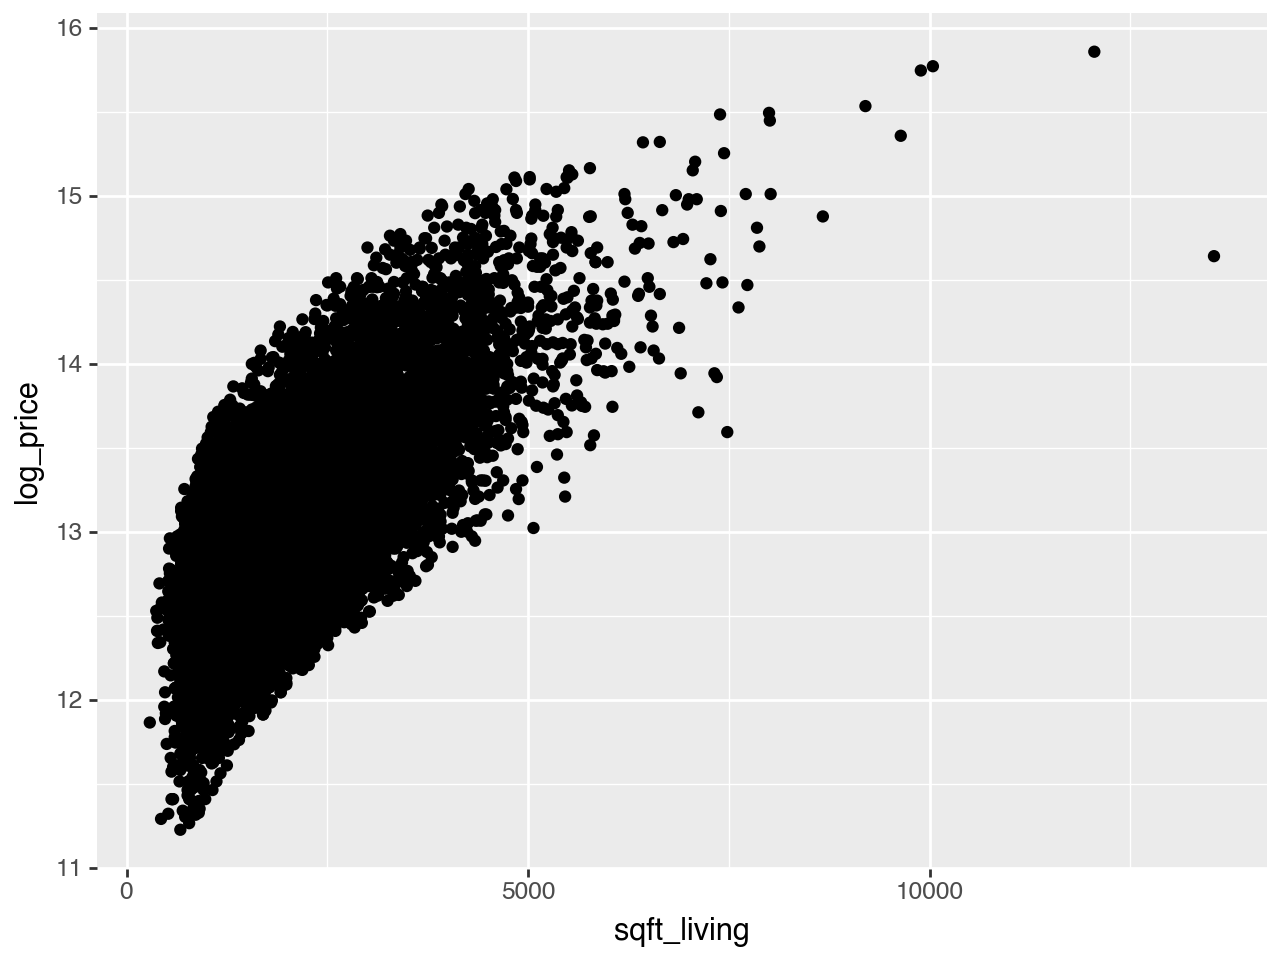

In [6]:
(ggplot(df, aes(x = 'sqft_living', y = 'log_price')) + 
       geom_point())

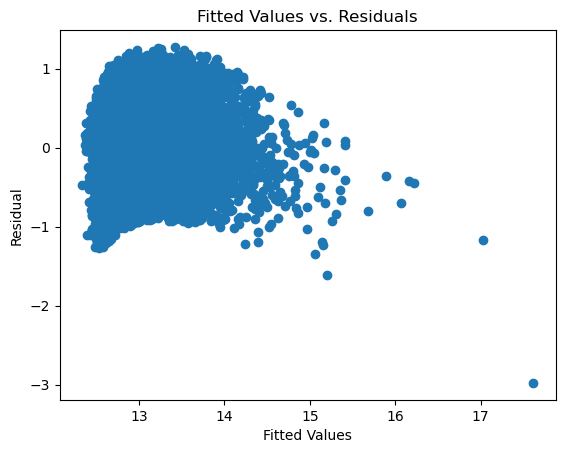

In [7]:
f2 = 'log_price~sqft_living'
model2 = smf.ols(formula=f2, data=df).fit()
p2 = model2.fittedvalues
res2 = model2.resid
plt.scatter(p2,res2)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

### The heteroskedasticity is improved, but now we see some non-linearity between x and y. 

### This suggests we may need to transform the predictor too, in order to find a linear relationship between  the response and predictor. 

### Transforming the Predictor

A heuristic for transforming $x$ is just to look at the scatterplot of $x$ vs. the response in question and see what function the scatterplot approximates.

If we are using `sqft_living` to predict `log_price`, the scatterplot looks like $y = \log(x)$ or maybe $y = \sqrt{x}.$

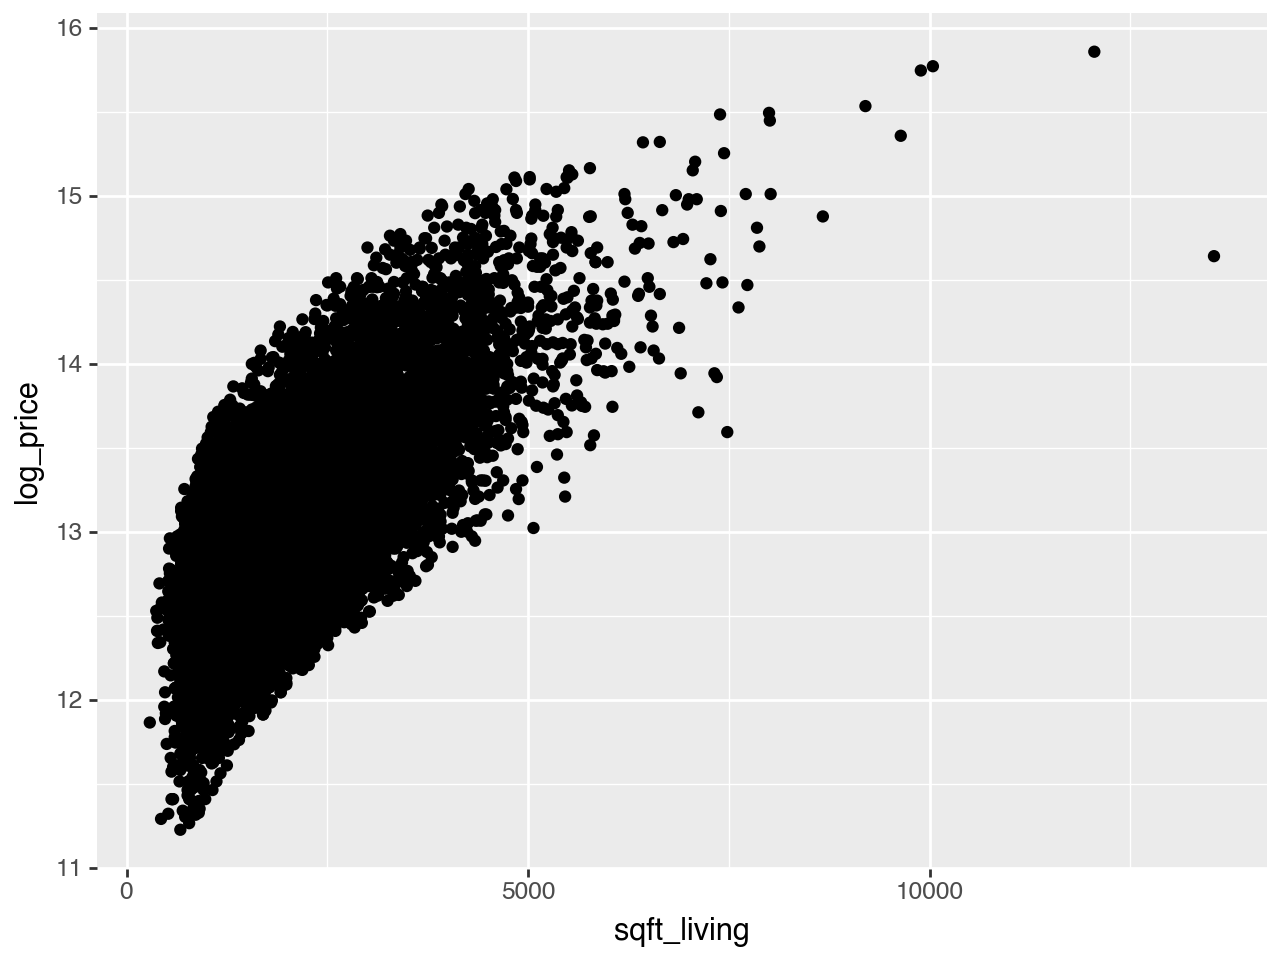

In [8]:
(ggplot(df, aes(x = 'sqft_living', y = 'log_price')) + 
       geom_point())

### We can try both...

### If we use log: 

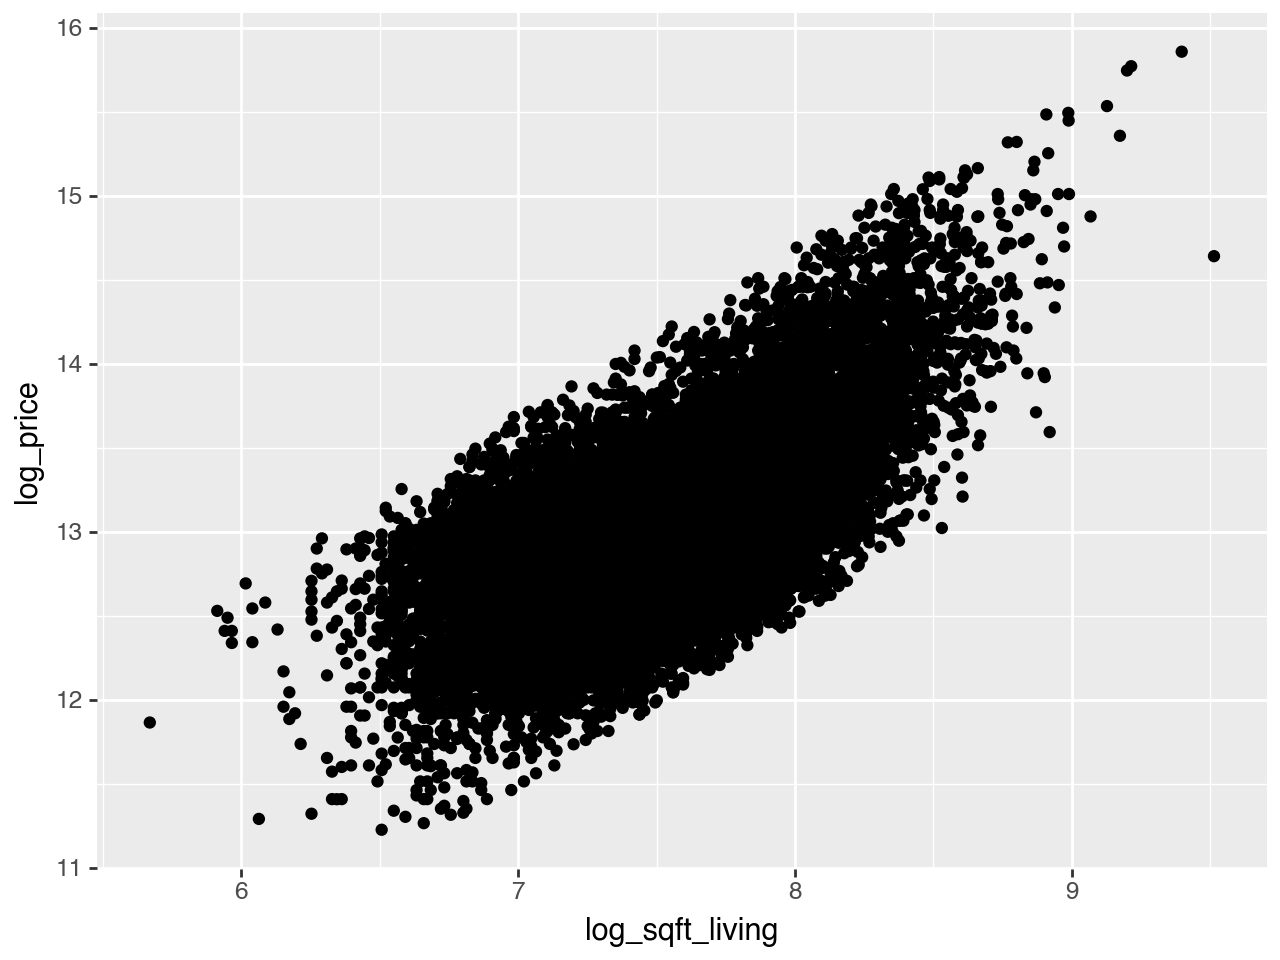

In [9]:
df['log_sqft_living'] = np.log(df['sqft_living'])

(ggplot(df, aes(x = 'log_sqft_living', y = 'log_price')) + 
       geom_point())

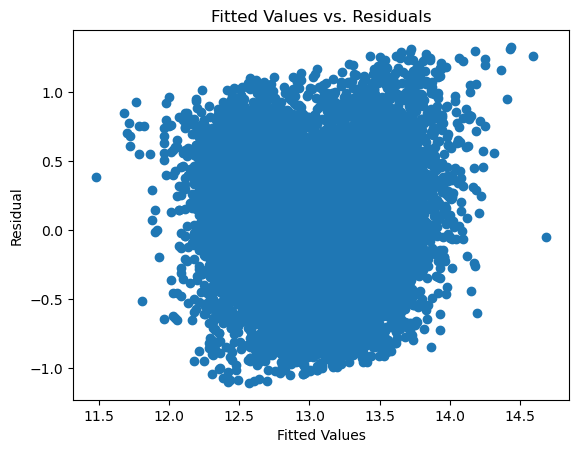

In [10]:
f3 = 'log_price~log_sqft_living'
model3 = smf.ols(formula=f3, data=df).fit()
p3 = model3.fittedvalues
res3 = model3.resid
plt.scatter(p3,res3)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [11]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.808e+04
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:32:36   Log-Likelihood:                -10240.
No. Observations:               21613   AIC:                         2.048e+04
Df Residuals:                   21611   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7299      0.047    143.001      0.000       6.638       6.822
log_sqft_living     0.8368      0.006    134.459      0.000       0.825       0.849
==============================================================================
Omnibus:                      123.344   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.759
Skew:                           0.142   Prob(JB):                     1.98e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### If we use sqrt:

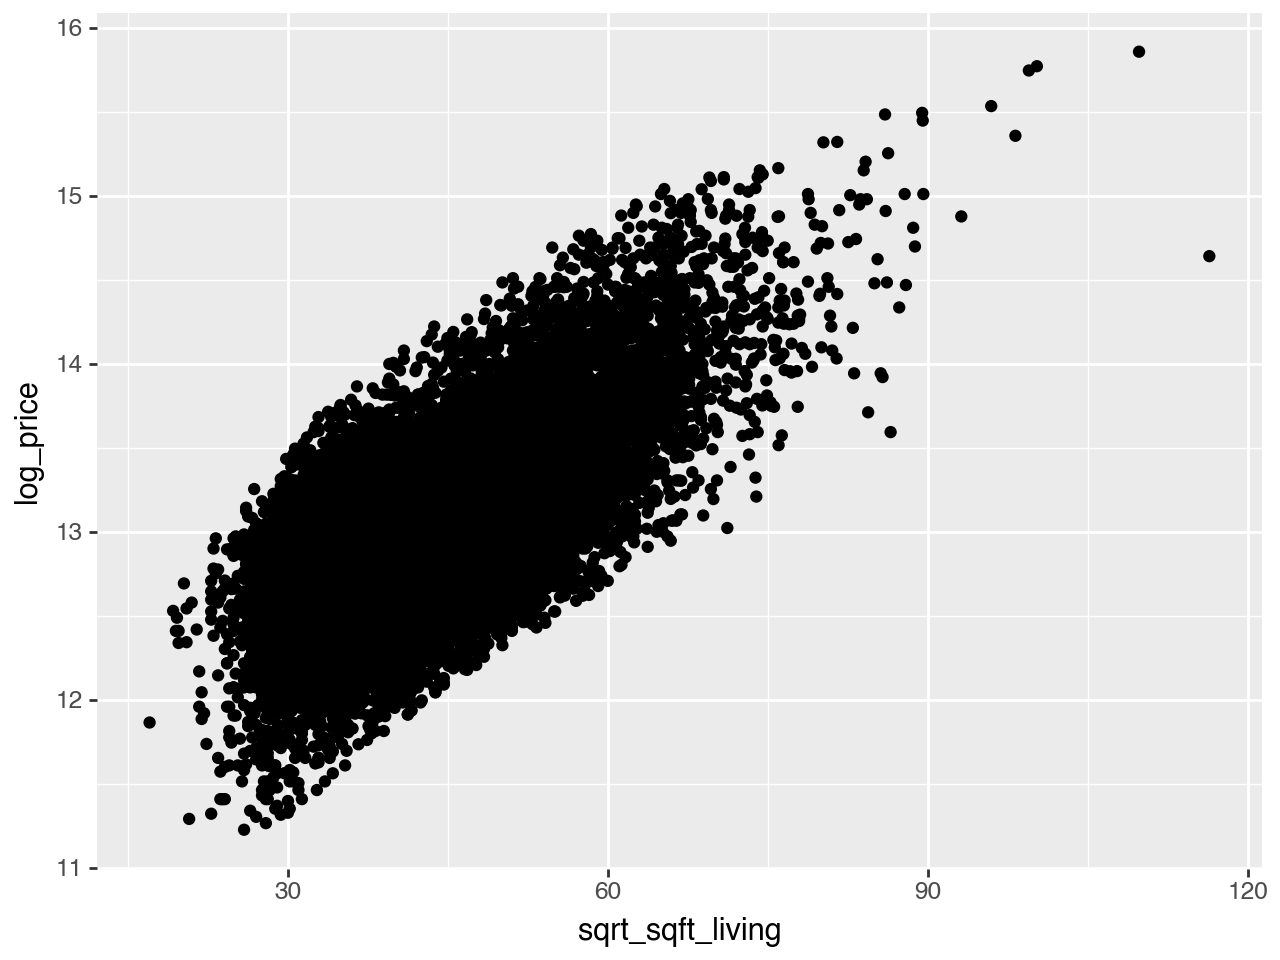

In [12]:
df['sqrt_sqft_living'] = np.sqrt(df['sqft_living'])


(ggplot(df, aes(x = 'sqrt_sqft_living', y = 'log_price')) + 
       geom_point())

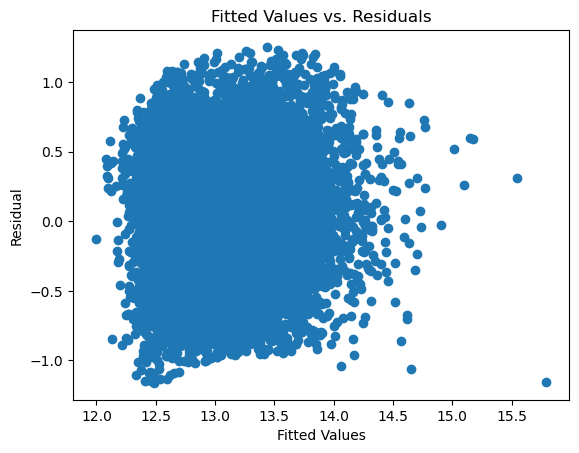

In [13]:
f4 = 'log_price~sqrt_sqft_living'
model4 = smf.ols(formula=f4, data=df).fit()
p4 = model4.fittedvalues
res4 = model4.resid
plt.scatter(p4,res4)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.show()

### Either works – I think log price ~ log sqft looks a little bit nicer in terms of the residual plot.

#### Note:  Transformation can be applicable even when we don't have heteroskedasticity -- for example if there's a nonlinear relationship between x and y. 

#### A general strategy to identify which transformations are most appropriate  is to use the Box-Cox transformation method. This is helpful, for example, if I couldn't guess that log or sqrt were reasonable functions to use based off of a visual inspection. See, e.g., https://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html.

## Another solution to address heteroskedasticity: Robust standard errors
    
It is common to use "robust standard errors" in econometric applications. We can access the robust standard errors, or Heteroskedasticity-Consistent Standard Errors (HCE) using  `statsmodels` methods:

The robust estimated variance matrix is calculated as:

$Var_{HC}(\hat{\beta}) = (X^T X)^{-1} X^T diag(e_i^2) X (X^T X)^{-1}$

in line with White (1980).

This adjustment tries to downweigh the impact of increasing residuals in the variance estimation step.

Notice that if $e_i^2 \approx \sigma^2$ for all i, the formula reduces to the usual variance matrix for beta hat: 

$Var(\hat{\beta}) = \sigma^2 (X^T X)^{-1}.$

In [14]:
credit = pd.read_csv('../Data/Credit.csv')

#orginal model that we know having heteroskedasticity problem
model =smf.ols('Balance ~ Income + Rating + Cards +Age + Education \
                + Gender + Student + Married + Ethnicity',data=credit).fit()

#extract HCE variance-coviance matrix
var_HC =model.cov_HC0
var_HC

array([[ 1.28979518e+03, -2.85353537e+01, -1.93737996e+01,
        -1.91773618e+01, -1.21102507e+02, -1.31108552e+02,
         2.15189155e+00, -9.87186508e-01, -2.83436775e+01,
        -4.19545031e+00, -4.02601264e+01],
       [-2.85353537e+01,  1.04540615e+02, -1.76173734e+01,
        -9.13676854e+00,  3.60555120e+00, -2.99505322e+00,
         1.95705491e-01, -3.60836602e-02,  1.37253190e+00,
        -1.93788690e-01, -5.71573694e-01],
       [-1.93737996e+01, -1.76173734e+01,  2.60173417e+02,
         1.19331093e+01, -1.82455379e+01, -6.48625401e+00,
        -7.32623436e-01,  1.69110939e-01, -1.18638848e+00,
        -2.39572478e-02, -1.69790633e+00],
       [-1.91773618e+01, -9.13676854e+00,  1.19331093e+01,
         1.09805461e+02, -2.66797583e+01, -1.78231341e+01,
         2.22313056e-01, -5.20147833e-02,  1.69160764e+00,
        -1.79079061e-01, -9.93094775e-01],
       [-1.21102507e+02,  3.60555120e+00, -1.82455379e+01,
        -2.66797583e+01,  2.11832833e+02,  1.03655948e+02,
  

In [15]:
#sometimes we may not care to see the corrected SE values themselves, 
#we can extract the corrected t test and p values directly if we just care about inference results
print(np.round(model.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

                            Coef.  Std.Err.         t    P>|t|     [0.025  \
Intercept              -549.31402  35.91372 -15.29538  0.00000 -619.92330   
Gender[T.Female]        -10.71056  10.22451  -1.04754  0.29550  -30.81278   
Student[T.Yes]          416.43756  16.12989  25.81775  0.00000  384.72489   
Married[T.Yes]          -15.10961  10.47881  -1.44192  0.15013  -35.71180   
Ethnicity[T.Asian]       21.76158  14.55448   1.49518  0.13568   -6.85370   
Ethnicity[T.Caucasian]   10.64919  12.43574   0.85634  0.39234  -13.80048   
Income                   -7.77460   0.23385 -33.24542  0.00000   -8.23437   
Rating                    3.97896   0.06399  62.17709  0.00000    3.85314   
Cards                     3.96537   3.37691   1.17426  0.24101   -2.67390   
Age                      -0.64159   0.30335  -2.11500  0.03507   -1.23801   
Education                -0.37986   1.62674  -0.23351  0.81549   -3.57815   

                           0.975]  
Intercept              -478.70473  
Gen

In [16]:
#Compare to the orginal model summary, numbers are slightly changed.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     757.8
Date:                Thu, 25 Sep 2025   Prob (F-statistic):          4.46e-248
Time:                        12:32:36   Log-Likelihood:                -2415.4
No. Observations:                 400   AIC:                             4853.
Df Residuals:                     389   BIC:                             4897.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -549.3140     35.085    -15.657      0.000    -618.293    -480.335
Gender[T.Female]         -10.7106     10.325     -1.037      0.300     -31.010       9.589
Student[T.Yes]           416.4376     17.336     24.021      0.000     382.353     450.522
Married[T.Yes]           -15.1096     10.728     -1.408      0.160     -36.202       5.983
Ethnicity[T.Asian]        21.7616     14.678      1.483      0.139      -7.096      50.619
Ethnicity[T.Caucasian]    10.6492     12.716      0.837      0.403     -14.351      35.649
Income                    -7.7746      0.244    -31.878      0.000      -8.254      -7.295
Rating                     3.9790      0.055     72.332      0.000       3.871       4.087
Cards                      3.9654      3.793      1.045      0.296      -3.492      11.422
Age                       -0.6416      0.306     -2.096      0.037      -1.243      -0.040
Education                 -0.3799      1.659     -0.229      0.819      -3.642       2.882
==============================================================================
Omnibus:                       15.651   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.769
Skew:                           0.490   Prob(JB):                     0.000228
Kurtosis:                       2.789   Cond. No.                     2.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Another solution: Weighted least squares 


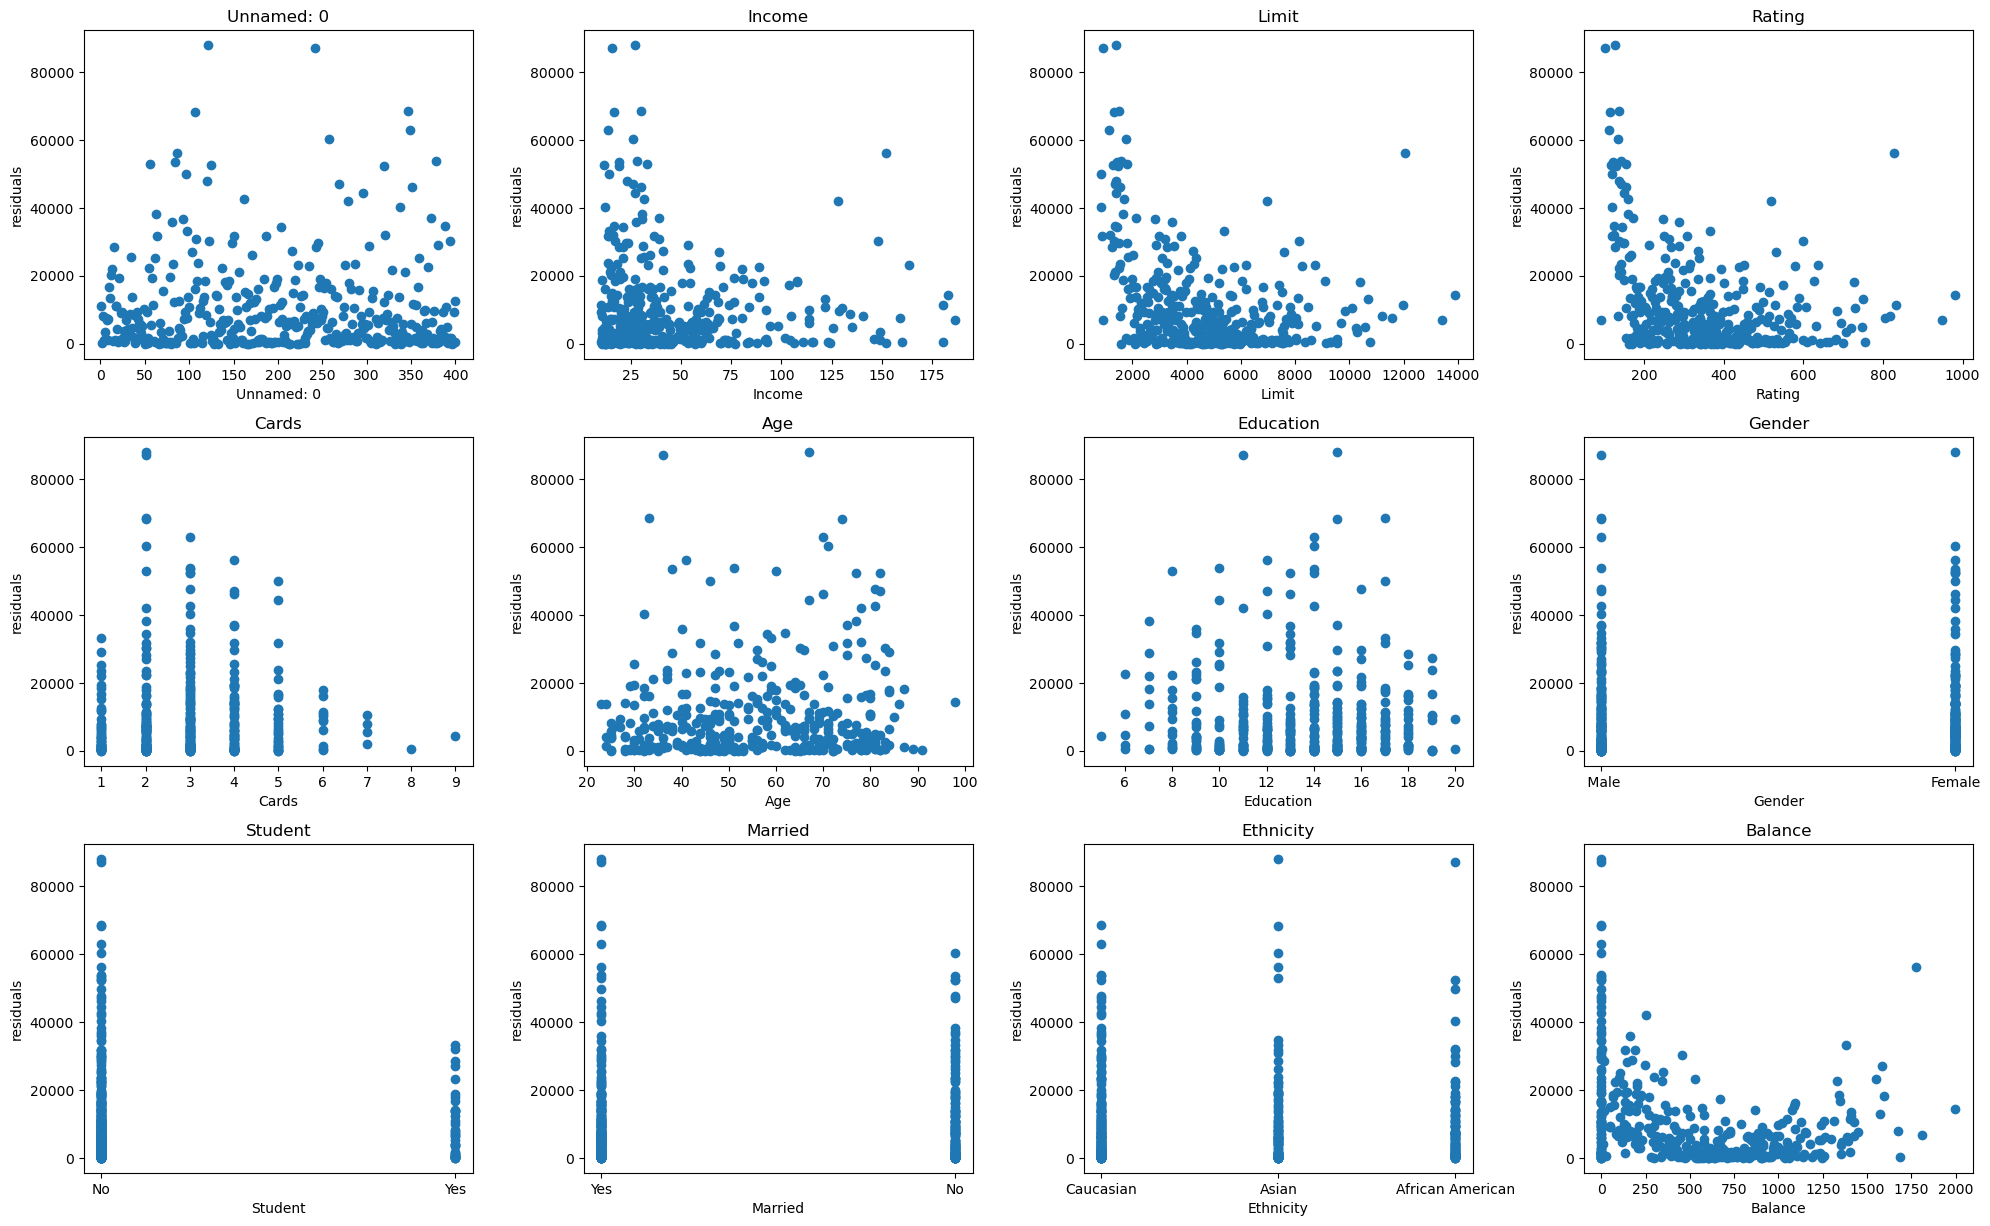

In [17]:
plt.figure(figsize=(20, 16))

# i: index
for i, col in enumerate(credit.columns):
    plt.subplot(4, 4, i+1)
    x = credit[col]
    y = model.resid**2
    plt.plot(x, y, 'o')

    plt.tight_layout()
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('residuals')
    
    # looks like residuals are proportional to Income, Limit, and Rating
    
plt.show()  

#### One method of performing weighted least squares is to regress each observation's squared residual onto the predictors causing heteroskedasticity, and then use the fitted value's absolute value to weigh each observation:

In [18]:
credit["res_sq"] = model.resid**2
model_res = smf.ols("res_sq ~ Rating", data=credit).fit()  #Here we don't also use Limit since it's highly collinear with Rating
weight = model_res.fittedvalues #\sigmahat^2_i
weight = abs(weight) #controls for negatives -- makes sure we don't extrapolate out of non-neg values
weight = weight**(-1/2) #inverse square root
credit['weight'] = weight #new weights for each row

In [19]:
y=credit.Balance
x=credit[['Income', 'Rating','Cards','Age','Education']] #or some other combo of predictors... model selection not the focus here

In [20]:
mod_wls = sm.WLS(y,x.astype(float), credit['weight'])
mod_res = mod_wls.fit()
print(mod_res.summary())

                                 WLS Regression Results                                
Dep. Variable:                Balance   R-squared (uncentered):                   0.952
Model:                            WLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              1581.
Date:                Thu, 25 Sep 2025   Prob (F-statistic):                   1.27e-258
Time:                        12:32:37   Log-Likelihood:                         -2673.0
No. Observations:                 400   AIC:                                      5356.
Df Residuals:                     395   BIC:                                      5376.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Why does this work?

## Consider the usual OLS setup:

$$
Y \sim \mathcal{N}(X\beta, \, \sigma^2 I)
\quad \text{(homoskedastic error)}
$$

But in heteroskedastic situations:

$$
Y \sim \mathcal{N}(X\beta, \, \Sigma)
\quad \text{(general covariance matrix)}
$$

e.g. errors are independent but 
$$\mathrm{Var}(e_i) \neq \sigma^2 \; \forall i.$$

Instead we have something like: $$\mathrm{Var}(e_i) = \sigma^2_i ~~~\forall i, \quad\text{so}$$

$$
\Sigma =
\begin{pmatrix}
\sigma_1^2 & 0 & \cdots & 0 \\
0 & \sigma_2^2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_n^2
\end{pmatrix}
$$
and the model is really
$$
Y = X\beta + \varepsilon, \quad \mathrm{Var}(\varepsilon) = \Sigma
$$

---

## Consider the transformation:

$$
\tilde{Y} = \Sigma^{-1/2} Y, 
\quad \tilde{X} = \Sigma^{-1/2} X,
\quad \tilde{\varepsilon} = \Sigma^{-1/2} \varepsilon
$$
Now we see the new variance is:
$$
\begin{aligned}
\mathrm{Var}(\tilde{\varepsilon}) 
&= \mathrm{Var}(\Sigma^{-1/2} \varepsilon) \\
&= \Sigma^{-1/2} \, \mathrm{Var}(\varepsilon) \, (\Sigma^{-1/2})^T \\
&= \Sigma^{-1/2} \, \Sigma \, \Sigma^{-1/2} \\
&= I_n
\end{aligned}
$$

---

## Transformed model:

$$
\tilde{Y} = \tilde{X}\beta + \tilde{\varepsilon}, 
\quad \mathrm{Var}(\tilde{\varepsilon}) = I_n
$$

This is just OLS!

$$
\hat{\beta} = (\tilde{X}^T \tilde{X})^{-1} \tilde{X}^T \tilde{Y}
$$

$$
= \big( (\Sigma^{-1/2} X)^T (\Sigma^{-1/2} X) \big)^{-1}
\big( (\Sigma^{-1/2} X)^T (\Sigma^{-1/2} Y) \big)
$$

$$
= (X^T \Sigma^{-1} X)^{-1} (X^T \Sigma^{-1} Y)
\quad \text{(WLS solution)}
$$


Technically we really need this:
$$
\hat{\beta}= (X^T \hat{\Sigma}^{-1} X)^{-1} (X^T \hat{\Sigma}^{-1} Y)
\quad \text{(WLS solution)}
$$